In [ ]:
!pip install tensorflow transformers

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from datetime import datetime
import numpy as np
import json

In [2]:
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("json version:", json.__version__)

TensorFlow version: 2.17.1
NumPy version: 1.26.4
json version: 2.0.9


In [3]:
def load_json_dataset(file_path):
  with open(file_path, "r") as f:
    data = json.load(f)
  return data

In [4]:
# Load Dataset
dir = "./dataset_findup.json"
data = load_json_dataset(dir)

In [5]:
def calculate_duration(start_date, end_date):
  """
  Calculate the duration in years and months between two dates.
  Args:
      start_date (str): Start date in the format 'YYYY-MM'
      end_date (str): End date in the format 'YYYY-MM' or present
  Returns:
      float: Duration in years (e.g., 1.5 for 1 year and 6 months)
  """

  date_format = "%b %Y"
  try:
    start = datetime.strptime(start_date, date_format)
    if end_date.lower() == "present":
      end = datetime.now()
    else:
      end = datetime.strptime(end_date, date_format)
    duration = (end.year - start.year) * 12 + (end.month - start.month)
    return round(duration / 12, 2)

  except:
    print(f'Error parsing dates: {e}')
    return 0

In [6]:
def extract_features(data):
  """
  Extract numerical and textual features from the dataset
  Args:
      data (list): Parsed JSON data
      job_requirements (dict): Job-specific skill requirements.
  Returns:
      tuple: Lists of texts, numerical features, and labels
  """

  texts = []
  numerical_features = []
  scores = []

  for entry in data:
    for name, details in entry.items():
      skills = details.get("Skills", [])
      certifications = details.get("Certification", [])
      personal_info = details.get("Personal Info", {})
      work_experience = details.get("Work Experience", [])

      # 1. Skills Score
      max_skills = 20
      skills_score = min(len(skills) / max_skills, 1.0) * 100

      # 2. Certification Score
      max_certification = 10
      certification_score = min(len(certifications) / max_certification, 1.0) * 100

      # 3. Degree Relevance Score
      degree = personal_info.get("Degree", " ")
      degree_map = {
          'highschool': 10,
          'bachelor': 20,
          'master': 30,
          'phd': 40,
      }
      degree_score = degree_map.get(degree.lower().split(" ")[0], 0) * 2.5

      # 4. Work Experience
      total_experience = sum(
          calculate_duration(exp.get("Start Date", ""), exp.get("End Date", "")) for exp in work_experience
      )
      max_experience = 5
      experience_score = min(total_experience / max_experience, 1.0) * 100

      # Combine features into Numerical inputs
      numerical_features.append([skills_score, certification_score, degree_score, experience_score])

      # Combined textual data for tokenizer
      combined_text = " ".join(skills + certifications)
      texts.append(combined_text)

      # Final CV Score (weighted average of components)
      final_score = (0.3 * skills_score + 0.2 * certification_score +
                     0.2 * degree_score + 0.3 * experience_score)
      scores.append(final_score)

  return texts, numerical_features, scores

In [24]:
texts, numerical_features, scores = extract_features(data)

In [8]:
data[0]

{'XENA ROSITA': {'Personal Info': {'Phone Number': '+621928614366',
   'Email': 'xenarosita@gmail.com',
   'Github': 'github.com/xenarosita',
   'LinkedIn': 'https://www.linkedin.com/in/xenarosita/',
   'Degree': "Bachelor's in Computer Science"},
  'Skills': ['Vue.js',
   'PHP',
   'C++',
   'PostgreSQL',
   'Node.js',
   'MySQL',
   'Git',
   'AWS',
   'Google Cloud',
   'GraphQL'],
  'Work Experience': [{'Company Name': 'ByteWorks',
    'Start Date': 'Mar 2022',
    'End Date': 'May 2022',
    'Position': 'Product Manager Intern',
    'Description': ['At this role, I leveraged my skills in project management to deliver excellent results.',
     'I played a key role in optimizing our workflows which contributed to our project successes.']}],
  'Certification': ['Certified Kubernetes Administrator']}}

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
def tokenize_texts(texts):
  return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")

tokenized_texts = tokenize_texts(texts)

In [26]:
def create_model():
  # BERT Input
  input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

  # BERT Model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  bert_output = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

  # Numerical Features Input
  numerical_input = tf.keras.layers.Input(shape=(4,), name='numerical_features')

  # Dense Layers from Numerical Features
  x_num = tf.keras.layers.Dense(64, activation='relu')(numerical_input)
  x_num = tf.keras.layers.Dropout(0.3)(x_num)
  x_num = tf.keras.layers.Dense(32, activation='relu')(numerical_input)

  # Concatenate BERT and Numerical Features
  x = tf.keras.layers.concatenate([bert_output, x_num])
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  output = tf.keras.layers.Dense(1, activation='linear')(x)

  model = tf.keras.Model(inputs=[input_ids, attention_mask, numerical_input], outputs=output)

  # Freeze all layers in BERT
  for layer in bert_model.layers:
    layer.trainable = False

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=2e-03),
      loss='mse',
      metrics=['mae'],
  )

  return model

In [27]:
model = create_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [28]:
train_size = int(0.7 * len(texts))
X_train = [tokenized_texts['input_ids'][:train_size], tokenized_texts['attention_mask'][:train_size], numerical_features[:train_size]]
y_train = scores[:train_size]

X_val = [tokenized_texts['input_ids'][train_size:], tokenized_texts['attention_mask'][train_size:], numerical_features[train_size:]]
y_val = scores[train_size:]

In [29]:
# Convert numerical features to tensors
numerical_features_train = tf.convert_to_tensor(numerical_features[:train_size], dtype=tf.float32)
numerical_features_val = tf.convert_to_tensor(numerical_features[train_size:], dtype=tf.float32)

In [30]:
# Create training and validation datasets
train_data = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_texts['input_ids'][:train_size],
        'attention_mask': tokenized_texts['attention_mask'][:train_size],
        'numerical_features': numerical_features_train
    },
    y_train
))

In [31]:
val_data = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_texts['input_ids'][train_size:],
        'attention_mask': tokenized_texts['attention_mask'][train_size:],
        'numerical_features': numerical_features_val
    },
    y_val
))

In [32]:
# Batch the datasets
train_data = train_data.batch(8).shuffle(100)
val_data = val_data.batch(8)

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor ='loss',
  patience = 5,
  restore_best_weights = True
)

In [34]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=25, callbacks=[early_stopping])

Epoch 1/25
9/9 [==============================] - 20s 664ms/step - loss: 215.2612 - mae: 10.9774 - val_loss: 110.7750 - val_mae: 10.3184
Epoch 2/25
9/9 [==============================] - 1s 156ms/step - loss: 53.7495 - mae: 6.1708 - val_loss: 6.8363 - val_mae: 2.0691
Epoch 3/25
9/9 [==============================] - 1s 156ms/step - loss: 34.4274 - mae: 4.3932 - val_loss: 3.4394 - val_mae: 1.5026
Epoch 4/25
9/9 [==============================] - 1s 176ms/step - loss: 18.1197 - mae: 3.1009 - val_loss: 6.3099 - val_mae: 1.9985
Epoch 5/25
9/9 [==============================] - 1s 173ms/step - loss: 28.8690 - mae: 3.8731 - val_loss: 3.3636 - val_mae: 1.5040
Epoch 6/25
9/9 [==============================] - 1s 160ms/step - loss: 26.0797 - mae: 3.7996 - val_loss: 5.7215 - val_mae: 1.9660
Epoch 7/25
9/9 [==============================] - 1s 125ms/step - loss: 19.2546 - mae: 3.3138 - val_loss: 3.6599 - val_mae: 1.5028
Epoch 8/25
9/9 [==============================] - 1s 120ms/step - loss: 24.98

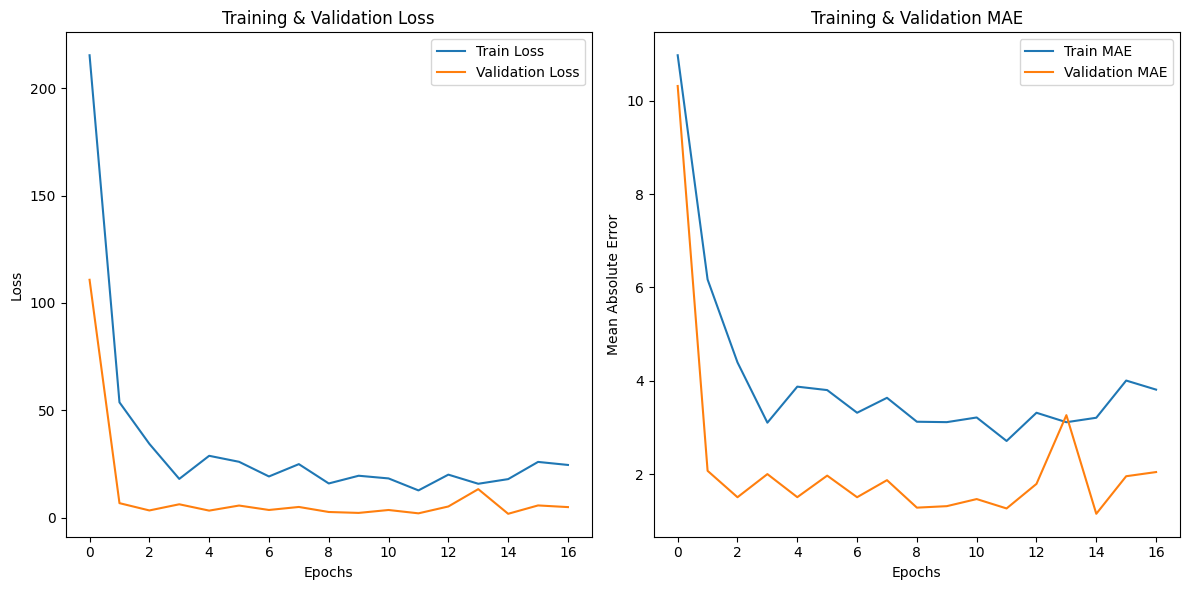

In [35]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training & Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()



4/4 [==============================] - 4s 91ms/step


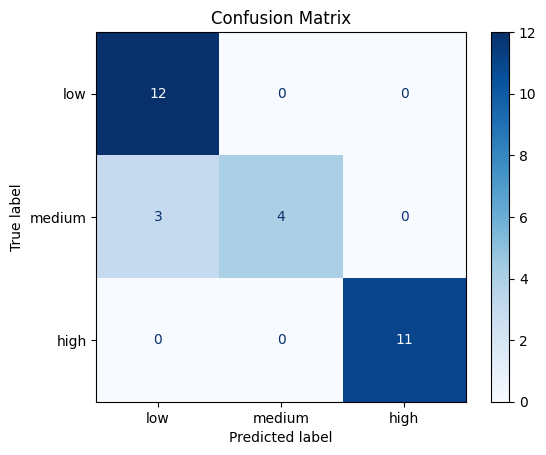

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def classify(scores, thresholds=(20, 30)):
    classes = []
    for score in scores:
        if score < thresholds[0]:
            classes.append("low")
        elif score < thresholds[1]:
            classes.append("medium")
        else:
            classes.append("high")
    return classes

# Predict on validation data
predicted_scores = model.predict(val_data)
predicted_classes = classify(predicted_scores.flatten())  # Flatten to 1D

# Convert true validation scores to classes
true_classes = classify(y_val)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=["low", "medium", "high"])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "medium", "high"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [37]:
# input_ids: (None, 128)
# attention_mask: (None, 128)
# numerical_features: (None, 128)
model.save('cv_scoring.h5')

print('Model saved as "cv_scoring_model"')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as "cv_scoring_model"


In [38]:
model_load = tf.keras.models.load_model(
    'cv_scoring.h5',
    custom_objects={"TFBertModel": TFBertModel}
)
print('Model succesfully loaded')
model_load.summary()

Model succesfully loaded
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7            

In [39]:
cv_ika = {
        "IKA SANTOSO": {
            "Personal Info": {
                "Phone Number": "+623239288207",
                "Email": "ikasantoso@gmail.com",
                "Github": "github.com/ikasantoso",
                "LinkedIn": "https://www.linkedin.com/in/ikasantoso/",
                "Degree": "Bachelor's in Information Technology"
            },
            "Skills": [
                "React",
                "Data Analysis",
                "Git",
                "Node.js",
                "Kotlin",
                "Vue.js",
                "Android Development",
                "Google Cloud",
                "Data Analysis",
                "SQL",
                "MySQL",
                "Docker",
                "GraphQL",
                "UI/UX Design",
                "PostgreSQL"
            ],
            "Work Experience": [
                {
                    "Company Name": "CodePulse",
                    "Start Date": "Jul 2018",
                    "End Date": "Jul 2019",
                    "Position": "Frontend Developer",
                    "Description": [
                        "My experience included mentoring junior team members and fostering a collaborative work environment.",
                        "Throughout my tenure, I took the initiative in leading team retrospectives.",
                        "At this role, I leveraged my skills in team collaboration to deliver excellent results.",
                        "I utilized various technologies and methodologies, further enhancing my expertise in software development."
                    ]
                }
            ],
            "Certification": [
                "AWS Certified Solutions Architect",
                "UX/UI Design Certification",
                "Certified Ethical Hacker"
            ]
        }
    }

In [55]:
def extract_features_self(data):
  """
  Extract numerical and textual features from the dataset
  Args:
      data (list): Parsed JSON data
      job_requirements (dict): Job-specific skill requirements.
  Returns:
      tuple: Lists of texts, numerical features, and labels
  """

  texts = []
  numerical_features = []

  for name, details in data.items():
    skills = details.get("Skills", [])
    certifications = details.get("Certification", [])
    personal_info = details.get("Personal Info", {})
    work_experience = details.get("Work Experience", [])

    # 1. Skills Score
    max_skills = 20
    skills_score = min(len(skills) / max_skills, 1.0) * 100

    # 2. Certification Score
    max_certification = 10
    certification_score = min(len(certifications) / max_certification, 1.0) * 100

    # 3. Degree Relevance Score
    degree = personal_info.get("Degree", " ")
    degree_map = {
        'highschool': 10,
        'bachelor': 20,
        'master': 30,
        'phd': 40,
    }
    degree_score = degree_map.get(degree.lower().split(" ")[0], 0) * 2.5

    # 4. Work Experience
    total_experience = sum(
        calculate_duration(exp.get("Start Date", ""), exp.get("End Date", "")) for exp in work_experience
    )
    max_experience = 5
    experience_score = min(total_experience / max_experience, 1.0) * 100

    # Combine features into Numerical inputs
    numerical_features.append([skills_score, certification_score, degree_score, experience_score])

    # Combined textual data for tokenizer
    combined_text = " ".join(skills + certifications)
    texts.append(combined_text)

  return texts, numerical_features

In [57]:
texts, numerical_features = extract_features_self(cv_ika)

In [61]:
def preprocess_data_self(texts, numerical_features, labels=None):
  """
  Preprocess text data and numerical features.
  Args:
      texts (list): List of text strings.
      numerical_features (list or np.ndarray): Numerical feature vectors.
      labels (list): Target scores (optional for inference).
  Returns:
      tf.data.Dataset: Tensorflow Dataset
  """
  # BERT tokenizer from TensorFlow Hub
  tokenized_texts = tokenize_texts(texts)

  # Convert Numerical Features to Tensors
  numerical_features = tf.convert_to_tensor(numerical_features, dtype=tf.float32)

  inputs = {
    'input_ids': tokenized_texts['input_ids'][:train_size],
    'attention_mask': tokenized_texts['attention_mask'][:train_size],
    'numerical_features': numerical_features
  }

  return inputs

In [64]:
processed_data = preprocess_data_self(texts, numerical_features)
prediction1 = model_load(processed_data)

predicted_score = (prediction1.numpy().flatten()[0] + 1)
print(f"Predicted CV Score: {predicted_score}")

Predicted CV Score: 30.904407501220703
